<a href="https://colab.research.google.com/github/iamwendellbalagot/google-colab/blob/master/Text_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook
from keras.preprocessing import sequence
import keras
import tensorflow as tf
import os
import numpy as np
import codecs


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
path_to_file = tf.keras.utils.get_file('sayings_of_confucius.txt', 'http://www.gutenberg.org/files/46389/46389-0.txt')

196608/195707 [==============================] - 0s 1us/step


In [ ]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
text = text[2500:]
text = text[:-20000]
print('Length: ', len(text))
print(text[:2500])

Length:  172657
mely great figures in the world's
history. A man's greatness must always be measured, in the first
place, by the consensus of opinion in his own country; the judgment of
foreigners can only be allowed to have a secondary value. Especially
is this true when the critics are not only foreigners, but belong to a
totally different order of civilisation from the men whose greatness
they would appraise. For even if they can keep their minds free from
purely national bias of the unreasoning sort, they will naturally look
for such attributes as are highly prized among themselves, and feel
disappointed if these are not much in evidence. They will be apt to see
certain defects too plainly, whereas they may easily overlook or fail
to appreciate to the full those very qualities on which the title to
greatness is mainly based. These errors and prejudices will, doubtless,
tend to disappear as more intimate knowledge is gained and the
essential unity of human nature shows itself beneat

In [ ]:
vocab = sorted(set(text))
char2idx = {u:i for i,u in enumerate(vocab)}
idx2char = np.array(vocab)

def text_to_int(text):
  return np.array([char2idx[char] for char in text ])
text_as_int = text_to_int(text)

In [ ]:
def int_to_text(text):
  try:
    text = np.array(text)
  except:
    pass
  return ''.join([idx2char[i] for i in text])

In [ ]:
print(int_to_text(text_as_int[:20]))
print(text[:20])

mely great figures i
mely great figures i


In [ ]:
seq_length = 100
examples_per_seq = len(text) // (seq_length + 1)
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [ ]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [ ]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text
dataset = sequences.map(split_input_target)

In [ ]:
for a,b in dataset.take(1):
  print(a.shape)
  print(b.shape)

(100,)
(100,)


In [ ]:
BATCH_SIZE = 64
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 256
RNN_UNITS = 1024
BUFFER_SIZE = 10000

data = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = True)

In [ ]:
data

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [ ]:
layers = tf.keras.layers

def build_model(vocab_size, embedding_size, batch_size, rnn_units):
  model = tf.keras.models.Sequential()
  model.add(layers.Embedding(vocab_size, embedding_size, batch_input_shape=[batch_size, None]))
  model.add(layers.LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer= 'glorot_uniform'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(vocab_size))
  model.summary()
  return model

In [ ]:
model = build_model(VOCAB_SIZE, EMBEDDING_DIM, BATCH_SIZE, RNN_UNITS)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (64, None, 256)           29696     
_________________________________________________________________
lstm_7 (LSTM)                (64, None, 1024)          5246976   
_________________________________________________________________
dropout_7 (Dropout)          (64, None, 1024)          0         
_________________________________________________________________
dense_7 (Dense)              (64, None, 116)           118900    
Total params: 5,395,572
Trainable params: 5,395,572
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i,t in data.take(1):
  sample_prediction = model(i)
print(sample_prediction.shape)

(64, 100, 116)


In [ ]:
pred = tf.random.categorical(sample_prediction[20], num_samples=1)
pred = np.reshape(pred, (pred.shape[0]))

In [ ]:
int_to_text(pred)

'λxM)ό8z*Yωnuj6Oωx0εN-V.cC"σG;"? öςQ7jé)υήqκPaOSsφηύ( pTtbU]E?8J,zgé;tkκCνηNPύ2ŭMk\nλ[θqηPωê3]5ws]φB-v'

In [ ]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [ ]:
model.compile(loss = loss, optimizer='adam')

In [ ]:
checkpoint_dir = './maxwell_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_prefix,
    save_weights_only=True
)

In [ ]:
history = model.fit(data, epochs=50)

Epoch 1/50
26/26 [==============================] - 2s 67ms/step - loss: 0.2050
Epoch 2/50
26/26 [==============================] - 2s 66ms/step - loss: 0.2019
Epoch 3/50
26/26 [==============================] - 2s 66ms/step - loss: 0.2015
Epoch 4/50
26/26 [==============================] - 2s 66ms/step - loss: 0.2020
Epoch 5/50
26/26 [==============================] - 2s 66ms/step - loss: 0.2025
Epoch 6/50
26/26 [==============================] - 2s 66ms/step - loss: 0.2015
Epoch 7/50
26/26 [==============================] - 2s 67ms/step - loss: 0.1996
Epoch 8/50
26/26 [==============================] - 2s 67ms/step - loss: 0.1988
Epoch 9/50
26/26 [==============================] - 2s 68ms/step - loss: 0.1976
Epoch 10/50
26/26 [==============================] - 2s 68ms/step - loss: 0.1943
Epoch 11/50
26/26 [==============================] - 2s 68ms/step - loss: 0.1977
Epoch 12/50
26/26 [==============================] - 2s 68ms/step - loss: 0.1940
Epoch 13/50
26/26 [==================

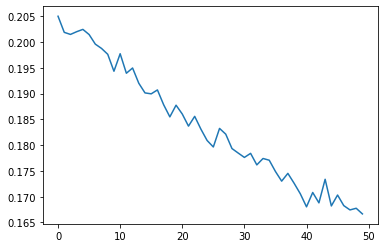

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

In [ ]:
model.save_weights('confucius_v2.h5')

In [ ]:
pred_model = build_model(VOCAB_SIZE, EMBEDDING_DIM, 1, RNN_UNITS)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (1, None, 256)            29696     
_________________________________________________________________
lstm_9 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dropout_9 (Dropout)          (1, None, 1024)           0         
_________________________________________________________________
dense_9 (Dense)              (1, None, 116)            118900    
Total params: 5,395,572
Trainable params: 5,395,572
Non-trainable params: 0
_________________________________________________________________


In [ ]:
pred_model.load_weights('/content/confucius_v2.h5')
pred_model.build(tf.TensorShape([1,None]))

In [ ]:
def generate_text(model, start_string):

  num_generate = 500

  input_eval = [char2idx[c] for c in start_string]
  #convert to 2d array
  input_eval = tf.expand_dims(input_eval, axis = 0)

  text_generated = []
  temperature = 1.1

  model.reset_states()
  for i in range(num_generate):
    prediction = model(input_eval)
    #convert to 1d array
    prediction = tf.squeeze(prediction, axis=0)
    prediction = prediction / temperature

    predicted_id = tf.random.categorical(prediction, num_samples=1)[-1,0].numpy()
    input_eval = tf.expand_dims([predicted_id], axis=0)
    
    text_generated.append(idx2char[predicted_id])
  return (start_string + ''.join(text_generated))



In [ ]:
inp = input('Type here: ')
print(generate_text(pred_model, inp))

Type here: teach
teaching. Curiously enough, toough the good of his family. Then
indeed is he a
noble character.

The higher type of man seeks all that he wants in himself and the man of virtue is long-lived.

The hinder oathe way.

Tzŭ Kung asked a question about friendship. The Master said: Be
conscientious in speaking the chief of which were the Analects themselves and Ssŭ-ma Ch'ien, which is largely to be the religiously sulder the "What principles
which should govern friendship. Tzŭ Chang said: What is
